In [1]:
import timeflow as tflow
import timesynth as ts
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Regular time series

#### Dataset generation using TimeSynth

In [2]:
#Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=20)
#Sampling regular time samples
regular_time_samples = time_sampler.sample_regular_time(num_points=200)

In [3]:
#Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)

In [4]:
#Initializing Gaussian noise
#white_noise = ts.noise.GaussianNoise(std=0.3)

In [5]:
#Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=None)
#Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(regular_time_samples)

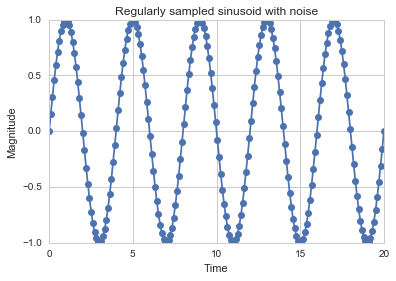

In [6]:
#Plotting the series
plt.plot(regular_time_samples, samples, marker='o')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Regularly sampled sinusoid with noise')

#### Building training and testing set

In [7]:
num_training_points = 100
X = samples[:-1]
Y = samples[1:]
X_train = X[:num_training_points]
Y_train = Y[:num_training_points]
X_test = X[num_training_points:]
Y_test = Y[num_training_points:]
X_train = np.reshape(X_train,(len(X_train), 1))
Y_train = np.reshape(Y_train,(len(Y_train), 1))
X_test = np.reshape(X_test,(len(X_test), 1))
Y_test = np.reshape(Y_test,(len(Y_test), 1))

#### Building the network

In [8]:
input_size = 1
hidden_size = 10
output_size = 1

In [9]:
inputs = tflow.placeholders.prediction.input_placeholder(input_size)
input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size)
lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)
reg_layer = tflow.layers.RegressionLayer(hidden_size, output_size, lstm_layer)
output_layer = tflow.layers.OutputLSTMLayer(output_size, reg_layer)

In [10]:
y = tflow.placeholders.prediction.output_placeholder(output_size)

In [11]:
outputs = output_layer.get_outputs()
# Defining MSE as the loss function
loss_func = tf.reduce_mean(tf.pow(tf.sub(outputs, y),2))

In [12]:
# Training with Adadelta Optimizer
train_step = tf.train.RMSPropOptimizer(learning_rate=0.05).minimize(loss_func)

In [13]:
# Starting tensorflow session
sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [15]:
for i in range(100):
    sess.run(train_step,feed_dict={inputs:X_train, y:Y_train})
    if (i+1)%10 == 0:
        print i+1, str(sess.run(loss_func,feed_dict={inputs:X_train, y:Y_train}))

10 0.482499
20 0.481656
30 0.481506
40 0.480704
50 0.469875
60 0.234282
70 0.0135658
80 0.0144253
90 0.0240101
100 0.0191846


#### Test output

In [18]:
monitor = AutomatedTrainingMonitor(inputs, y, X_train, Y_train,
                                   train_step, loss_func, sess, training_steps=500,
                                   validation_input=X_test, validation_output=Y_test,
                                   early_stopping_rounds=60)

In [19]:
monitor.train()

Final Validation loss:  0.0189358014613
Number of Iterations:  119


In [20]:
output = sess.run(outputs,feed_dict={inputs:X_test})

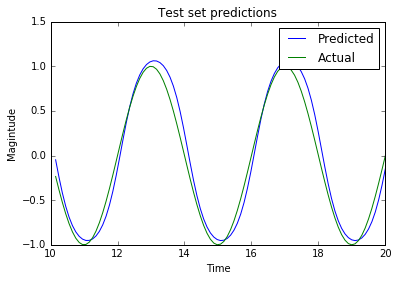

In [21]:
plt.plot(regular_time_samples[num_training_points+1:], output, label = 'Predicted')
plt.plot(regular_time_samples[num_training_points+1:], Y_test, label = 'Actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magintude')
plt.title('Test set predictions');

#### Irregular dataset prediction

In [2]:
#Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=30)
#Sampling regular time samples
irregular_time_samples = time_sampler.sample_irregular_time(num_points=600, keep_percentage=50)

In [3]:
#Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
#Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.3)

In [4]:
#Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=None)
#Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(irregular_time_samples)

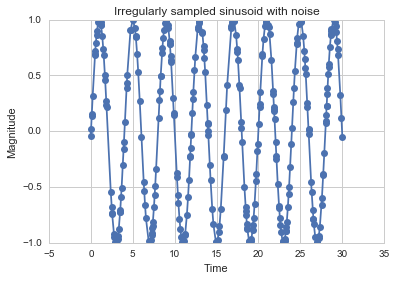

In [5]:
#Plotting the series
plt.plot(irregular_time_samples, samples, marker='o')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Irregularly sampled sinusoid with noise')

In [6]:
X, Y, time_vector = tflow.features.irregular_prediction(irregular_time_samples, samples)

In [7]:
num_training_points = 100
num_validation_points = 100
X_train = X[:num_training_points, :]
Y_train = Y[:num_training_points, :]
X_valid = X[num_training_points:num_training_points+num_validation_points, :]
Y_valid = Y[num_training_points:num_training_points+num_validation_points, :]
X_test = X[num_training_points+num_validation_points:, :]
Y_test = Y[num_training_points+num_validation_points:, :]

In [8]:
input_size = 4
hidden_size = 10
output_size = 1

In [9]:
with tf.variable_scope('Input'):
    inputs = tflow.placeholders.prediction.input_placeholder(input_size)
with tf.variable_scope('Input_LSTM_Layer'):
    input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size)
with tf.variable_scope('LSTM_Layer'):
    lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)
with tf.variable_scope('Regression_Layer'):
    reg_layer = tflow.layers.RegressionLayer(hidden_size, output_size, lstm_layer)
with tf.variable_scope('Output_LSTM_Layer'):
    output_layer = tflow.layers.OutputLSTMLayer(output_size, reg_layer)

In [10]:
y = tflow.placeholders.prediction.output_placeholder(output_size)

In [11]:
outputs = output_layer.get_outputs()
# Defining MSE as the loss function
with tf.variable_scope('RMSE'):
    loss_func = tflow.utils.metrics.RMSE(outputs, y)
# Defining R2 for additional logging
with tf.variable_scope('R2'):
    R2 = tflow.utils.metrics.R2(outputs, y)

In [12]:
tf.scalar_summary("MSE", loss_func)
tf.scalar_summary("R2", R2)
summary_op = tf.merge_all_summaries()

In [13]:
# Training with Adadelta Optimizer
train_step = tf.train.RMSPropOptimizer(learning_rate=0.05).minimize(loss_func)

In [14]:
# Starting tensorflow session
sess=tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [15]:
#Setting up log directory for tensorboard
logs_path = 'tmp/irr/1'
writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

In [16]:
monitor = tflow.trainer.AutomatedTrainingMonitor(inputs, y, X_train, Y_train,
                                                 train_step, loss_func, sess, training_steps=500,
                                                 validation_input=X_valid, validation_output=Y_valid,
                                                 early_stopping_rounds=60, summary_op=summary_op,
                                                 writer_obj=writer)

In [17]:
writer = monitor.train()

Final Validation loss:  0.0140811689198
Number of Iterations:  132


In [19]:
#Use this to reset training monitor
monitor.reset_early_stopped()

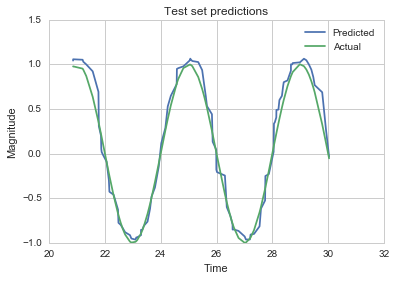

In [18]:
output = sess.run(outputs,feed_dict={inputs:X_test})
plt.plot(time_vector[num_training_points+num_validation_points:], output, label = 'Predicted')
plt.plot(time_vector[num_training_points+num_validation_points:], Y_test, label = 'Actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Test set predictions');

In [19]:
predicted_series = sess.run(outputs,feed_dict={inputs:X})

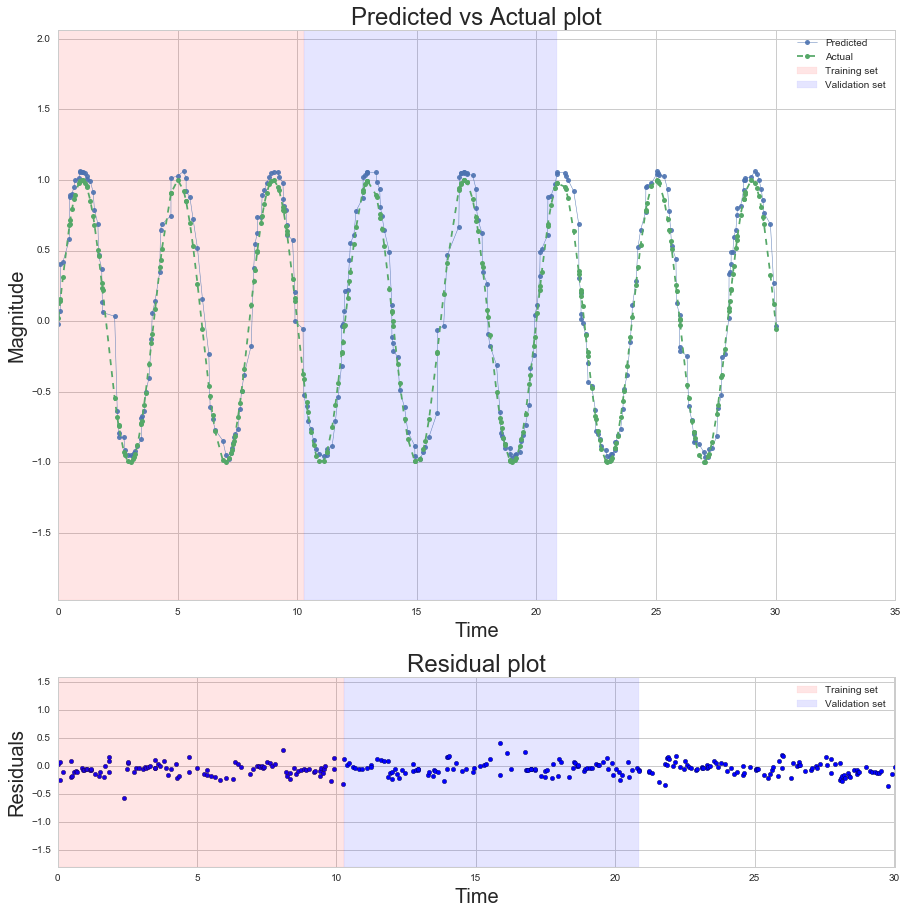

In [20]:
tflow.utils.plotting.plot_residuals(predicted_series, Y, time_vector,
                                    num_training_points, num_validation_points)